# Training notebook 

In this notebook, we will create the graph, build the STGNN model, perform training, and evaluation.

# Create SoilWaterDataset object 

SoilWaterDataset is a fundamental object created based on TabularDataset from the TSL library. Using this object, we will be able to enabling efficient loading, preprocessing, and spatiotemporal structuring of data.



In [52]:
from typing import Optional, Union, List
import numpy as np
import pandas as pd 

from tsl.datasets.prototypes import TabularDataset
from tsl.ops.similarities import gaussian_kernel

class SoilWaterDataset(TabularDataset):

    similarity_options = {'distance', 'grid'}

    def __init__(self,
                 root: str = None
                 ):

        self.root = root

        # Load data
        # target, mask, u, dist, metadata = self.load()
        target, mask, u = self.load()

        covariates = {
            'u': (u),
            # 'metadata' : (metadata),
            # 'distances': (dist)
        }

        super().__init__(target=target,
                         mask=mask,
                         covariates=covariates,
                         similarity_score='distance',
                         temporal_aggregation='mean',
                         spatial_aggregation='mean',
                         name='SoilWaterDataset')

    def load(self):
        """
        Load data from files.

        Returns:
            tuple: Containing target, mask, covariates, distances, and metadata.
        """
        target_path = f"{self.root}target.npy"
        mask_path = f"{self.root}mask.npy"
        # dist_path = f"{self.root}distance_matrix.npy"
        covariates_path = f"{self.root}covariates.npy"
        metadata_path = f"{self.root}metadata.npy"

        target = np.load(target_path)
        mask = np.load(mask_path)
        u = np.load(covariates_path)
        # dist = np.load(dist_path)
        # metadata = np.load(metadata_path)

        return target, mask, u, # dist, metadata


    def compute_similarity(self, method: str, **kwargs):
        """
        Compute similarity matrix based on the specified method.

        Args:
            method (str): The similarity computation method ('distance' or 'grid').
            **kwargs: Additional keyword arguments for similarity computation.

        Returns:
            numpy.ndarray: Computed similarity matrix.

        Raises:
            ValueError: If an unknown similarity method is provided.
        """
        if method == "distance":
            # Calculate a Gaussian kernel similarity from the distance matrix, using a default or provided 'theta'
            theta = kwargs.get('theta', np.std(self.distances))
            return gaussian_kernel(self.distances, theta=theta)
        elif method == "grid":
            dist = self.distances.copy()
            dist[dist > 16] = np.inf  # keep only grid edges
            theta = kwargs.get('theta', 20)
            return gaussian_kernel(dist, theta=theta)
        else:
            raise ValueError(f"Unknown similarity method: {method}")

In [53]:
dataset = SoilWaterDataset(root='soil-water-forecasting/modeling-pipeline/data/05_model_input/')

In [54]:
dataset.target

array([[[0.14876582],
        [0.14876582],
        [0.14876582],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       [[0.14942625],
        [0.14942625],
        [0.14942625],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       [[0.15036774],
        [0.15036774],
        [0.15036774],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       ...,

       [[0.34311864],
        [0.34311864],
        [0.34311864],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       [[0.34331864],
        [0.34331864],
        [0.34331864],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       [[0.35298058],
        [0.35298058],
        [0.35298058],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]]], dtype=float32)

In [55]:
print(f"Has missing values: {dataset.has_mask}")

Has missing values: True


In [56]:
dataset.mask

array([[[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       ...,

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]]])

In [57]:
dataset.set_mask(dataset.mask)

In [58]:
dataset.covariates

{'u': array([[[ 4.07929420e-01,  1.03629112e-01,  2.42928116e+02, ...,
           0.00000000e+00,  2.73551035e+04,  1.00000000e+00],
         [ 4.07929420e-01,  1.03629112e-01,  2.42928116e+02, ...,
           0.00000000e+00,  2.73551035e+04,  1.00000000e+00],
         [ 4.07929420e-01,  1.03629112e-01,  2.42928116e+02, ...,
           0.00000000e+00,  2.73551035e+04,  1.00000000e+00],
         ...,
         [-2.24294949e+00, -3.70980263e-01,  2.45420303e+02, ...,
           0.00000000e+00,  5.61181641e+00,  1.00000000e+00],
         [-2.23904324e+00, -3.37288857e-01,  2.45389053e+02, ...,
           0.00000000e+00,  6.21337891e+00,  1.00000000e+00],
         [-2.23513699e+00, -3.03597450e-01,  2.45359756e+02, ...,
           0.00000000e+00,  6.79541016e+00,  1.00000000e+00]],
 
        [[ 4.89461899e-01,  4.02355194e-02,  2.34145340e+02, ...,
           0.00000000e+00,  2.73551035e+04,  1.00000000e+00],
         [ 4.89461899e-01,  4.02355194e-02,  2.34145340e+02, ...,
           0.000

# Create connectivity to our graph 

Here, we adjust the connectivity to retain only the five nearest neighbors (knn=5) per node, while excluding self-loops and normalizing along the specified axis.

In [59]:
# dataset.distances

In [60]:
# sim = dataset.compute_similarity("distance")  # or dataset.compute_similarity()

In [61]:
# sim

In [62]:
# # Adjust connectivity to reduce the number of edges
# connectivity = dataset.get_connectivity(  
#     method='distance',
#     knn=4,     
#     include_self=False,
#     force_symmetric=True, 
#     layout="csr",
# )

In [63]:
import torch

connectivity = torch.load("soil-water-forecasting/modeling-pipeline/data/05_model_input/connectivity.pt")

/tmp/ipykernel_5962/3741746759.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  connectivity = torch.load("soil-water-forecasting/modeling-pipeline/data/05_model_input/co

# Create torch_dataset 

torch_dataset, created using SpatioTemporalDataset from the tsl library, structures time-series and spatial data (target, covariates, mask, and connectivity) into a form optimized for spatiotemporal model training, enabling easy handling of lookback windows and prediction horizons in forecasting tasks.


In [64]:
from tsl.data import SpatioTemporalDataset

# covariates=dict(u=dataset.covariates['u'])
covariates=dataset.covariates
mask = dataset.mask

horizon=6
window=12
stride=1

torch_dataset = SpatioTemporalDataset(target=dataset.dataframe(),
                                      mask=mask,
                                      covariates=covariates,
                                      connectivity=connectivity,
                                      horizon=horizon, 
                                      window=window, 
                                      stride=stride 
                                      )

In [65]:
torch_dataset.mask

tensor([[[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        ...,

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]]])

# Create datamodule

datamodule, created with SpatioTemporalDataModule, manages the SpatioTemporalDataset by applying scaling, splitting data into train/validation/test sets, and preparing data loaders with batch processing, enabling efficient, modular, and scalable data handling for deep learning models.

In [66]:
from tsl.data.preprocessing import StandardScaler, MinMaxScaler

scalers = {
    'target': MinMaxScaler(axis=(0, 1)),
    'u': MinMaxScaler(axis=(0, 1))
}

In [83]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
                                 
# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
# splitter = TemporalSplitter(val_len=0.1, test_len=0.2)
splitter = TemporalSplitter(val_len=0.1, test_len=0.023)

In [132]:
# Create a SpatioTemporalDataModule
datamodule = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    mask_scaling=True,
    splitter=splitter,
    batch_size=4, 
    workers=15
    )

print(datamodule)

SpatioTemporalDataModule(train_len=None, val_len=None, test_len=None, scalers=[target, u], batch_size=4)


In [133]:
datamodule.setup()

In [134]:
datamodule

SpatioTemporalDataModule(train_len=457, val_len=40, test_len=12, scalers=[target, u], batch_size=4)

# Create STGNN Model Architecture

The **TimeAndGraphAnisoModel** is built based on code from [HD-TTS
 repository](https://github.com/marshka/hdtts/blob/main/lib/nn/models/baselines/stgnns/time_and_graph_anisotropic.py) and the research paper by Cini et al. (2023d). This model utilizes spatiotemporal architectures equipped with anisotropic message passing for effective time and space representation.

### Reference
Cini, A., Marisca, I., Zambon, D., and Alippi, C. *Taming Local Effects in Graph-Based Spatiotemporal Forecasting.* In *Advances in Neural Information Processing Systems,* volume 36, pp. 55375–55393. Curran Associates, Inc., 2023.  
[https://arxiv.org/abs/2302.04071](https://arxiv.org/abs/2302.04071)


https://github.com/marshka/hdtts/blob/main/lib/nn/layers/anisotropic.py

In [135]:
from typing import Optional

import torch
from torch import nn, Tensor
from torch_geometric.nn import MessagePassing
from tsl.nn.blocks import RNNBase
from tsl.nn.layers import Dense, GraphGRUCellBase, Activation


class GraphAnisoConv(MessagePassing):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int = 1,
                 edge_dim: Optional[int] = None,
                 activation: str = 'leaky_relu'):
        super(GraphAnisoConv, self).__init__(aggr="add", node_dim=-2)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.msg_mlps = nn.ModuleList([
            nn.Sequential(
                nn.Linear(2 * (in_channels if i == 0 else out_channels),
                          out_channels),
                Activation(activation),
                nn.Linear(out_channels, out_channels),
            )
            for i in range(kernel_size)
        ])

        edge_dim = edge_dim or 1  # accommodate for edge_weight
        self.lin_edge = nn.Linear(edge_dim, out_channels, bias=False)

        self.gate_mlp = Dense(out_channels, 1, activation='sigmoid')

        self.skip_conn = nn.Linear(in_channels, out_channels)
        self.activation = Activation(activation)

    def forward(self, x, edge_index, edge_attr: Optional[Tensor] = None):
        """"""
        out, x_ = 0, x
        for idx in range(self.kernel_size):
            x_ = self.propagate(edge_index, idx=idx, x=x_, edge_attr=edge_attr)
            out += x_
        out = self.activation(out + self.skip_conn(x))
        return out

    def message(self, x_i, x_j, idx, edge_attr: Optional[Tensor] = None):
        mij = self.msg_mlps[idx](torch.cat([x_i, x_j], -1))
        if edge_attr is not None:
            if edge_attr.ndim == 1:  # accommodate for edge_weight
                edge_attr = edge_attr.view(-1, 1)
            mij = mij + self.lin_edge(edge_attr)
        return self.gate_mlp(mij) * mij


class GraphAnisoGRUCell(GraphGRUCellBase):

    def __init__(self, input_size: int, hidden_size: int,
                 edge_dim: Optional[int] = None,
                 activation: str = 'leaky_relu'):
        self.input_size = input_size
        # instantiate gates
        forget_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                     edge_dim=edge_dim, activation=activation)
        update_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                     edge_dim=edge_dim, activation=activation)
        candidate_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                        edge_dim=edge_dim,
                                        activation=activation)
        super(GraphAnisoGRUCell, self).__init__(hidden_size=hidden_size,
                                                forget_gate=forget_gate,
                                                update_gate=update_gate,
                                                candidate_gate=candidate_gate)


class GraphAnisoGRU(RNNBase):

    def __init__(self, input_size: int, hidden_size: int,
                 edge_dim: Optional[int] = None,
                 n_layers: int = 1, cat_states_layers: bool = False,
                 return_only_last_state: bool = False,
                 activation: str = 'leaky_relu'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        rnn_cells = [
            GraphAnisoGRUCell(input_size if i == 0 else hidden_size,
                              hidden_size, edge_dim=edge_dim,
                              activation=activation)
            for i in range(n_layers)
        ]
        super(GraphAnisoGRU, self).__init__(rnn_cells, cat_states_layers,
                                            return_only_last_state)

https://github.com/marshka/hdtts/blob/main/lib/nn/models/baselines/stgnns/prototypes.py

In [136]:
from typing import Optional, Union, List

import torch
from torch import Tensor, nn
from torch_geometric.typing import Adj
from tsl.nn.blocks import MLPDecoder
from tsl.nn.layers import MultiLinear, NodeEmbedding
from tsl.nn.models import BaseModel
from tsl.nn.utils import maybe_cat_exog
from tsl.utils import ensure_list


def maybe_cat_emb(x: Tensor, emb: Optional[Tensor]):
    if emb is None:
        return x
    if emb.ndim < x.ndim:
        emb = emb[[None] * (x.ndim - emb.ndim)]
    emb = emb.expand(*x.shape[:-1], -1)
    return torch.cat([x, emb], dim=-1)


class STGNN(BaseModel):
    available_embedding_pos = {'encoding', 'decoding'}

    def __init__(self, input_size: int, horizon: int,
                 n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Optional[
                     Union[str, List[str]]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 activation: str = 'elu'):
        super(STGNN, self).__init__()

        self.input_size = input_size
        self.horizon = horizon
        self.n_nodes = n_nodes
        self.output_size = output_size or input_size
        self.hidden_size = hidden_size
        self.exog_size = exog_size
        self.activation = activation

        # EMBEDDING
        if add_embedding_before is None:
            add_embedding_before = set()
        else:
            add_embedding_before = set(ensure_list(add_embedding_before))
            if not add_embedding_before.issubset(self.available_embedding_pos):
                raise ValueError("Parameter 'add_embedding_before' must be a "
                                 f"subset of {self.available_embedding_pos}")
        self.add_embedding_before = add_embedding_before

        if emb_size > 0:
            self.emb = NodeEmbedding(n_nodes, emb_size)
        else:
            self.register_module('emb', None)

        # ENCODER
        self.encoder_input = input_size + exog_size
        if 'encoding' in self.add_embedding_before and self.emb is not None:
            self.encoder_input += emb_size

        if use_local_weights is not None:
            self.use_local_weights = set(ensure_list(use_local_weights))
            if len(self.use_local_weights.difference(['encoder', 'decoder'])):
                raise ValueError("Parameter 'use_local_weights' must be "
                                 "'encoder', 'decoder', or both.")
        else:
            self.use_local_weights = set()

        if 'encoder' in self.use_local_weights:
            self.encoder = MultiLinear(self.encoder_input, hidden_size, n_nodes)
        else:
            self.encoder = nn.Linear(self.encoder_input, hidden_size)

        # DECODER
        self.decoder_input = hidden_size
        if 'decoding' in self.add_embedding_before and self.emb is not None:
            self.decoder_input += emb_size
        if 'decoder' in self.use_local_weights:
            raise NotImplementedError()
        else:
            self.decoder = MLPDecoder(input_size=self.decoder_input,
                                      hidden_size=self.hidden_size,
                                      output_size=self.output_size,
                                      horizon=self.horizon,
                                      activation=self.activation)

    def stmp(self, x: Tensor, edge_index: Adj,
             edge_weight: Optional[Tensor] = None,
             emb: Optional[Tensor] = None) -> Tensor:
        raise NotImplementedError

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: Optional[Tensor] = None,
                u: Optional[Tensor] = None,
                node_idx: Optional[Tensor] = None) -> Tensor:
        """"""
        # x: [batches steps nodes features]
        x = maybe_cat_exog(x, u)
        batch_size = x.size(0)
        emb = self.emb(expand=(batch_size, -1, -1),
                       node_index=node_idx) if self.emb is not None else None

        if 'encoding' in self.add_embedding_before and emb is not None:
            x = maybe_cat_emb(x, emb[:, None])

        # ENCODER   ###########################################################
        x = self.encoder(x)

        # SPATIOTEMPORAL MESSAGE-PASSING   ####################################
        out = self.stmp(x, edge_index, edge_weight, emb)

        # DECODER   ###########################################################
        if 'decoding' in self.add_embedding_before:
            out = maybe_cat_emb(out, emb)

        out = self.decoder(out)

        return out


class TimeAndSpace(STGNN):

    def __init__(self, input_size: int, horizon: int, stmp_conv: nn.Module,
                 n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Union[str, List[str]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 activation: str = 'elu'):
        super(TimeAndSpace, self).__init__(input_size=input_size,
                                           horizon=horizon,
                                           n_nodes=n_nodes,
                                           output_size=output_size,
                                           exog_size=exog_size,
                                           hidden_size=hidden_size,
                                           emb_size=emb_size,
                                           add_embedding_before=add_embedding_before,
                                           use_local_weights=use_local_weights,
                                           activation=activation)

        # STMP
        self.stmp_conv = stmp_conv

    def stmp(self, x: Tensor, edge_index: Adj,
             edge_weight: Optional[Tensor] = None,
             emb: Optional[Tensor] = None) -> Tensor:
        # spatiotemporal encoding
        out = self.stmp_conv(x, edge_index, edge_weight)
        return out


https://github.com/marshka/hdtts/blob/main/lib/nn/models/baselines/stgnns/time_and_graph_anisotropic.py

In [137]:
from typing import Union, List

class TimeAndGraphAnisoModel(TimeAndSpace):

    def __init__(self, input_size: int, horizon: int, n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Union[str, List[str]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 n_layers: int = 1,
                 activation: str = 'elu'):
        stmp_conv = GraphAnisoGRU(input_size=hidden_size,
                                  hidden_size=hidden_size,
                                  n_layers=n_layers,
                                  activation=activation,
                                  return_only_last_state=True)
        super(TimeAndGraphAnisoModel, self).__init__(
            input_size=input_size,
            horizon=horizon,
            stmp_conv=stmp_conv,
            n_nodes=n_nodes,
            output_size=output_size,
            exog_size=exog_size,
            hidden_size=hidden_size,
            emb_size=emb_size,
            add_embedding_before=add_embedding_before,
            use_local_weights=use_local_weights,
            activation=activation
        )


# Setup model 

Model is configured with hidden units, feed-forward layers, multiple SpatioTemporalConvNet blocks, and utilizes temporal and spatial convolution kernels, layer normalization, and gated mechanisms; it adapts to the dataset’s input size, number of nodes, horizon, and available exogenous features.

In [138]:
hidden_size = 32          # Number of hidden units
emb_size = 32
ff_size = 64             # Number of units in the feed-forward layers
n_layers = 3              # Number of SpatioTemporalConvNet blocks
temporal_kernel_size = 3  # Size of the temporal convolution kernel
spatial_kernel_size = 3   # Order of the spatial diffusion process
norm='layer'
gated=True

input_size = torch_dataset.n_channels
n_nodes = torch_dataset.n_nodes
horizon = torch_dataset.horizon
exog_size = torch_dataset.input_map.u.shape[-1] if 'u' in torch_dataset else 0

add_embedding_before = ['encoding', 'decoding']
activation = 'elu'

In [139]:
model = TimeAndGraphAnisoModel(
    input_size=input_size,
    horizon=horizon,
    n_nodes=n_nodes,
    output_size=input_size,
    exog_size=exog_size,
    hidden_size=hidden_size,
    emb_size=emb_size,
    add_embedding_before=add_embedding_before,
    activation=activation
)

# Print the model architecture
print(model)

TimeAndGraphAnisoModel(
  (emb): NodeEmbedding(n_nodes=64800, embedding_size=32)
  (encoder): Linear(in_features=53, out_features=32, bias=True)
  (decoder): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=64, out_features=32, bias=True)
          (activation): ELU(alpha=1.0)
          (dropout): Identity()
        )
      )
      (readout): Linear(in_features=32, out_features=6, bias=True)
    )
    (rearrange): Rearrange('b n (h f) -> b h n f', f=1, h=6)
  )
  (stmp_conv): GraphAnisoGRU(cell=GraphAnisoGRUCell, return_only_last_state=True)
)


In [140]:
def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

In [141]:
print_model_size(model)

Number of model (TimeAndGraphAnisoModel) parameters:   2099593


# Setup training 

This setup initializes a Predictor for the model with a masked mean-squared error loss function and multiple evaluation metrics (MSE, MAE, MAPE, and specific MSE at selected timesteps), then configures a Trainer using PyTorch Lightning with early stopping and model checkpointing based on validation MSE, gradient clipping to prevent exploding gradients, and 16-bit precision for efficient training.

In [142]:
from tsl.metrics.torch import MaskedMSE, MaskedMAE, MaskedMRE
from tsl.engines import Predictor

# Define the loss function
loss_fn = MaskedMAE()

# Setup metrics
metrics = {
    'mae': MaskedMAE(),
    'mse': MaskedMSE(),
    'mre': MaskedMRE(),
    'mae_at_1': MaskedMAE(at=0), 
    'mae_at_3': MaskedMAE(at=2), 
    'mae_at_6': MaskedMAE(at=5) 
}

In [143]:
# Setup predictor
predictor = Predictor(
    model=model,
    optim_class=torch.optim.Adam,
    optim_kwargs={'lr': 0.001},
    loss_fn=loss_fn,
    metrics=metrics
)


https://lightning.ai/docs/pytorch/stable/common/trainer.html

In [144]:
from pathlib import Path
from datetime import datetime
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

early_stop_callback = EarlyStopping(
    monitor='val_mse',
    patience=30,
    mode='min'
)

In [145]:
# Generate a timestamp for the logs directory
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Logs directory with timestamp
dirpath = Path(f'soil-water-forecasting/modeling-pipeline/data/06_models/TimeAndGraphAniso/logs/log_{timestamp}')

# Ensure the directory exists
dirpath.mkdir(parents=True, exist_ok=True)

# Model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=dirpath,
    save_top_k=1,
    monitor='val_mse',
    mode='min',
)

print(f"Checkpoints will be saved in: {dirpath}")

Checkpoints will be saved in: soil-water-forecasting/modeling-pipeline/data/06_models/TimeAndGraphAniso/logs/log_2024-12-10_14-12-52


In [146]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir=dirpath, name='TimeAndGraphAnisoModel')

In [147]:
# Setup trainer
trainer = pl.Trainer(max_epochs=100, 
                     logger=logger, 
                     limit_train_batches=100,
                     callbacks=[early_stop_callback, checkpoint_callback],
                     log_every_n_steps=2,
                     gradient_clip_val=5,    
                     precision=16
                     )

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Training 

In [148]:
# Set float32 matmul precision to 'medium' or 'high'
torch.set_float32_matmul_precision('medium')

1L40S

In [149]:
train = False

155 minut trening 42 GB VRAMU 

In [150]:
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

if train == True:
    trainer.fit(predictor, datamodule=datamodule)
    # Path to the best checkpoint
    best_checkpoint_path = checkpoint_callback.best_model_path
    predictor.load_model(best_checkpoint_path)
else:
    predictor.load_model('/teamspace/studios/this_studio/soil-water-forecasting/modeling-pipeline/data/06_models/TimeAndGraphAniso/logs/log_2024-12-09_16-20-37/epoch=96-step=9021.ckpt')


Predictor with already instantiated model is loading a state_dict from /teamspace/studios/this_studio/soil-water-forecasting/modeling-pipeline/data/06_models/TimeAndGraphAniso/logs/log_2024-12-09_16-20-37/epoch=96-step=9021.ckpt. Cannot  check if model hyperparameters are the same.


# Evaluation

In [151]:
predictor.freeze()

In [152]:
trainer.test(predictor, dataloaders=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Only args ['u', 'edge_index', 'x'] are forwarded to the model (TimeAndGraphAnisoModel).


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.008570093661546707    │
│         test_mae          │   0.008570094592869282    │
│       test_mae_at_1       │   0.007950722239911556    │
│       test_mae_at_3       │   0.008747817948460579    │
│       test_mae_at_6       │    0.00814320333302021    │
│         test_mre          │   0.012121928855776787    │
│         test_mse          │  0.00037064545904286206   │
└───────────────────────────┴───────────────────────────┘

[{'test_mae': 0.008570094592869282,
  'test_mae_at_1': 0.007950722239911556,
  'test_mae_at_3': 0.008747817948460579,
  'test_mae_at_6': 0.00814320333302021,
  'test_mre': 0.012121928855776787,
  'test_mse': 0.00037064545904286206,
  'test_loss': 0.008570093661546707}]

# Predict

In [153]:
# Assuming you have a datamodule set up
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()
test_dataloader = datamodule.test_dataloader()

# Count the number of batches
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)
num_test_batches = len(test_dataloader)

print(f"Number of training batches: {num_train_batches}")
print(f"Number of validation batches: {num_val_batches}")
print(f"Number of test batches: {num_test_batches}")


Number of training batches: 114
Number of validation batches: 10
Number of test batches: 3


In [ ]:
splitter.indices

## val data

In [154]:
predictions = trainer.predict(predictor, dataloaders=datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [155]:
predictions

[{'y': tensor([[[[0.3187],
            [0.3187],
            [0.3187],
            ...,
            [1.0000],
            [1.0000],
            [1.0000]],
  
           [[0.3202],
            [0.3202],
            [0.3202],
            ...,
            [1.0000],
            [1.0000],
            [1.0000]],
  
           [[0.3209],
            [0.3209],
            [0.3209],
            ...,
            [1.0000],
            [1.0000],
            [1.0000]],
  
           [[0.3158],
            [0.3158],
            [0.3158],
            ...,
            [1.0000],
            [1.0000],
            [1.0000]],
  
           [[0.3218],
            [0.3218],
            [0.3218],
            ...,
            [1.0000],
            [1.0000],
            [1.0000]],
  
           [[0.3269],
            [0.3269],
            [0.3269],
            ...,
            [1.0000],
            [1.0000],
            [1.0000]]],
  
  
          [[[0.3202],
            [0.3202],
            [0.3202],
       

In [ ]:
np.save('soil-water-forecasting/modeling-pipeline/data/07_model_output/predictions.npy', predictions)

In [ ]:
import torch
import numpy as np
import xarray as xr

# Path to the saved predictions
predictions_path = 'soil-water-forecasting/modeling-pipeline/data/07_model_output/predictions.npy'

# Load the predictions
# If you saved 'predictions' as a list, you might need to use allow_pickle=True
predictions = np.load(predictions_path, allow_pickle=True)

import xarray as xr

# Load the dataset
ds = xr.open_dataset('soil-water-forecasting/modeling-pipeline/data/04_feature/features.nc')

dates = pd.to_datetime(ds['valid_time'].values)

In [157]:
import torch
import xarray as xr
import numpy as np

# Assuming 'predictions' is your list of prediction dictionaries
# and 'ds' is your original xarray.Dataset loaded earlier

# Initialize lists to store all y and y_hat predictions
y_all_list = []
y_hat_all_list = []

for pred in predictions:
    # Extract 'y' and 'y_hat' and remove the last dimension (features)
    y_batch = pred['y'].squeeze(-1)       # Shape: (batch, horizon, nodes)
    y_hat_batch = pred['y_hat'].squeeze(-1)  # Shape: (batch, horizon, nodes)
    
    # Take the last step in the horizon for each sample in the batch
    y_last_steps = y_batch[:, -1, :]     # Shape: (batch, nodes)
    y_hat_last_steps = y_hat_batch[:, -1, :]  # Shape: (batch, nodes)
    
    # Append to the lists
    y_all_list.append(y_last_steps)
    y_hat_all_list.append(y_hat_last_steps)

# Concatenate all batches to form the complete arrays
y_all = torch.cat(y_all_list, dim=0).numpy()         # Shape: (12, nodes)
y_hat_all = torch.cat(y_hat_all_list, dim=0).numpy() # Shape: (12, nodes)

# Step 3: Extract test dates from the original dataset
test_dates = ds['valid_time'][-12:].values  # Shape: (12,)

# Verification
assert y_all.shape[0] == 12, f"Expected 12 predictions, got {y_all.shape[0]}"

# Step 4: Reshape y and y_hat to (time, latitude, longitude)
n_lat = 180
n_lon = 360

# Ensure that the total number of nodes matches
assert y_all.shape[1] == n_lat * n_lon, f"Expected {n_lat * n_lon} nodes, got {y_all.shape[1]}"

y_all_reshaped = y_all.reshape(12, n_lat, n_lon)          # Shape: (12, 180, 360)
y_hat_all_reshaped = y_hat_all.reshape(12, n_lat, n_lon)  # Shape: (12, 180, 360)

# Step 5: Create the xarray.Dataset
ds_pred = xr.Dataset(
    {
        'y': (('time', 'latitude', 'longitude'), y_all_reshaped),
        'y_hat': (('time', 'latitude', 'longitude'), y_hat_all_reshaped)
    },
    coords={
        'time': test_dates,
        'latitude': ds['latitude'].values,
        'longitude': ds['longitude'].values
    }
)

# Display the Dataset
print(ds_pred)

# # Optional: Save the Dataset
# ds_pred.to_netcdf('soil-water-forecasting/modeling-pipeline/data/07_predictions/predictions.nc')


<xarray.Dataset> Size: 6MB
Dimensions:    (time: 12, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 96B 2023-11-01 2023-12-01 ... 2024-10-01
  * latitude   (latitude) int64 1kB -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude  (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Data variables:
    y          (time, latitude, longitude) float32 3MB 0.3269 0.3269 ... 1.0 1.0
    y_hat      (time, latitude, longitude) float32 3MB 0.4275 0.2866 ... 0.9995


In [163]:
ds_pred

<xarray.Dataset> Size: 6MB
Dimensions:    (time: 12, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 96B 2023-11-01 2023-12-01 ... 2024-10-01
  * latitude   (latitude) int64 1kB -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude  (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Data variables:
    y          (time, latitude, longitude) float32 3MB 0.3269 0.3269 ... 1.0 1.0
    y_hat      (time, latitude, longitude) float32 3MB 0.4275 0.2866 ... 0.9995

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr

def plot_time_map(ds, time_idx=0, vmin=None, vmax=None):
    """
    Visualize y_hat (left) and y_true (right) for a specific time using a custom color scale.
    The map is centered at 0° longitude.

    Parameters:
    - ds: xarray.Dataset containing 'y' and 'y_hat' variables with dimensions (time, latitude, longitude)
    - time_idx: Index of the time coordinate to visualize
    - vmin: Minimum value for color scaling (optional)
    - vmax: Maximum value for color scaling (optional)
    """
    
    # Custom color scale
    color_scale = [
        [0.0, "darkred"],
        [0.1, "red"],
        [0.2, "orangered"],
        [0.3, "lightgreen"],
        [0.4, "limegreen"],
        [0.5, "green"],
        [0.55, "darkseagreen"],
        [0.6, "darkgreen"],
        [0.7, "lightblue"],
        [0.8, "skyblue"],
        [0.9, "deepskyblue"],
        [1.0, "blue"]
    ]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", color_scale)
    
    # Extract data for the given time
    y_hat_map = ds.y_hat.isel(time=time_idx).values
    y_true_map = ds.y.isel(time=time_idx).values  # Assuming 'y' is the true values
    
    # Coordinates
    lats = ds.latitude.values
    lons = ds.longitude.values
    time_val = pd.to_datetime(ds.time.values[time_idx])  # Ensure it's a Timestamp
    
    # Shift longitude from [0, 360] to [-180, 180] if necessary
    lons_shifted = np.where(lons > 180, lons - 360, lons)
    
    # Sort the longitudes and corresponding data
    sorted_indices = np.argsort(lons_shifted)
    lons_sorted = lons_shifted[sorted_indices]
    y_hat_sorted = y_hat_map[:, sorted_indices]
    y_true_sorted = y_true_map[:, sorted_indices]
    
    # Compute vmin/vmax if not provided
    if vmin is None:
        vmin = min(np.nanmin(y_hat_sorted), np.nanmin(y_true_sorted))
    if vmax is None:
        vmax = max(np.nanmax(y_hat_sorted), np.nanmax(y_true_sorted))
    
    # Calculate the data period (12 months before the target time)
    start_data_period = time_val - pd.DateOffset(months=12)
    end_data_period = time_val - pd.DateOffset(months=1)
    
    # Format the dates as YYYY-MM
    start_data_str = start_data_period.strftime("%Y-%m")
    end_data_str = end_data_period.strftime("%Y-%m")
    
    # Calculate the prediction month based on the target time
    prediction_month_str = time_val.strftime("%Y-%m")
    
    # Set up the plot with two subplots side by side
    fig, axes = plt.subplots(ncols=2, figsize=(14, 6), constrained_layout=True)
    fig.suptitle(
        f"Predictions based on {start_data_str} to {end_data_str}\n"
        f"Prediction month: {prediction_month_str}",
        fontsize=16, fontweight='bold'
    )
    
    # Function to plot each map
    def plot_map(ax, data, title, cmap, vmin, vmax):
        mesh = ax.pcolormesh(lons_sorted, lats, data, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Longitude", fontsize=12)
        ax.set_ylabel("Latitude", fontsize=12)
        ax.set_xlim([-180, 180])
        ax.set_ylim([-90, 90])
        ax.grid(True, linestyle='--', alpha=0.5)
        return mesh
    
    # Plot y_hat
    im_hat = plot_map(axes[0], y_hat_sorted, "y_hat", cmap, vmin, vmax)
    # Add colorbar for y_hat
    cbar_hat = plt.colorbar(im_hat, ax=axes[0], orientation='horizontal', fraction=0.046, pad=0.08)
    cbar_hat.set_label("y_hat value", fontsize=12)
    
    # Plot y_true
    im_true = plot_map(axes[1], y_true_sorted, "y_true", cmap, vmin, vmax)
    # Add colorbar for y_true
    cbar_true = plt.colorbar(im_true, ax=axes[1], orientation='horizontal', fraction=0.046, pad=0.08)
    cbar_true.set_label("y_true value", fontsize=12)
    
    plt.show()

# Example usage:
# Assuming `ds` is your dataset with dimensions including 'time', 'latitude', and 'longitude'.
# To plot for the first time index (e.g., 2023-11)
# plot_time_map(ds, time_idx=0)

# To plot for November 2023 specifically, ensure that time_idx corresponds to 2023-11


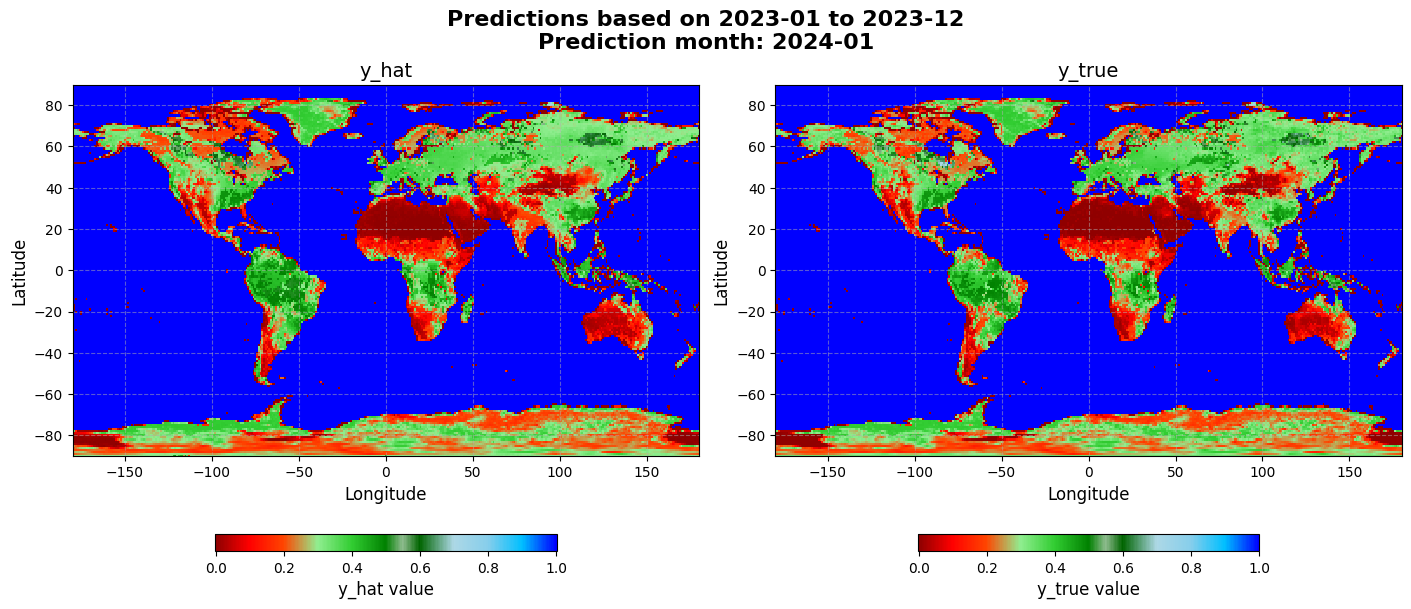

In [169]:
plot_time_map(ds_pred, time_idx=2)

In [78]:
import numpy as np
import pandas as pd
import torch
import xarray as xr

# 1. Load Metadata and Dates
metadata_array = np.load('soil-water-forecasting/modeling-pipeline/data/05_model_input/metadata.npy')  # Shape: (num_nodes, 2)
latitudes = metadata_array[:, 0]
longitudes = metadata_array[:, 1]
num_nodes = len(latitudes)
total_time_steps = len(dates)

In [79]:
metadata_array

array([[-90,   0],
       [-90,   1],
       [-90,   2],
       ...,
       [ 89, 357],
       [ 89, 358],
       [ 89, 359]])

In [80]:
# 2. Correctly Retrieve the Split Indices
split_indices = datamodule.splitter.indices
val_indices = split_indices['val']


In [83]:
import numpy as np
import pandas as pd
import xarray as xr

# Suppose we have the following from your previous steps:
# - `predictions` is a list of dictionaries returned by trainer.predict()
#   In this example, we'll use the first batch of predictions.
pred_dict = predictions[0]
y_true = pred_dict['y'].cpu().numpy()   # Shape: (num_test_samples, horizon, num_nodes, features)
y_hat = pred_dict['y_hat'].cpu().numpy() # Shape: (num_test_samples, horizon, num_nodes, features)
mask = pred_dict['mask'].cpu().numpy()  # Shape: (num_test_samples, horizon, num_nodes, features)

# You have:
# `metadata_array` with shape (num_nodes, 2) for lat/lon
# `dates` is an array of all dates corresponding to the original dataset
# `split_indices` is a dict with 'train', 'val', 'test'
val_indices = split_indices['val']
test_indices = split_indices['test']  # e.g. array([63, 64, 65, 66, 67, 68, 69])

num_test_samples = len(test_indices)
horizon = y_true.shape[1]     # Number of forecast steps
num_nodes = y_true.shape[2]   # Total nodes (lat * lon)
features = y_true.shape[3]    # Should be 1 for the target variable in this case

# From the metadata, extract latitudes and longitudes
latitudes = metadata_array[:, 0]  # shape: (num_nodes,)
longitudes = metadata_array[:, 1] # shape: (num_nodes,)

# Determine the latitude and longitude counts.
# For example, if original dataset has latitude: 181 and longitude: 360
# => 181 * 360 = 65160 nodes
latitude_count = 180
longitude_count = 360

# Reshape predictions from (num_test_samples, horizon, num_nodes, features)
# to (num_test_samples, horizon, latitude_count, longitude_count)
y_true_reshaped = y_true.reshape(num_test_samples, horizon, latitude_count, longitude_count, features)
y_hat_reshaped = y_hat.reshape(num_test_samples, horizon, latitude_count, longitude_count, features)
mask_reshaped = mask.reshape(num_test_samples, horizon, latitude_count, longitude_count, features)

# Retrieve the actual dates for the test samples
test_dates = dates[test_indices]  # This gives the datetime64 array for test samples

# If features = 1, we can squeeze that dimension out
y_true_reshaped = y_true_reshaped[..., 0]
y_hat_reshaped = y_hat_reshaped[..., 0]
mask_reshaped = mask_reshaped[..., 0]

# Create DataArrays
# Define coordinate arrays
da_y_true = xr.DataArray(
    y_true_reshaped,
    dims=("time", "horizon", "latitude", "longitude"),
    coords={
        "time": test_dates,
        "horizon": np.arange(1, horizon + 1),
        "latitude": np.linspace(-90, 90, latitude_count),
        "longitude": np.arange(0, longitude_count)
    },
    name='y_true'
)

da_y_hat = xr.DataArray(
    y_hat_reshaped,
    dims=("time", "horizon", "latitude", "longitude"),
    coords={
        "time": test_dates,
        "horizon": np.arange(1, horizon + 1),
        "latitude": np.linspace(-90, 90, latitude_count),
        "longitude": np.arange(0, longitude_count)
    },
    name='y_hat'
)

da_mask = xr.DataArray(
    mask_reshaped.astype(bool),
    dims=("time", "horizon", "latitude", "longitude"),
    coords={
        "time": test_dates,
        "horizon": np.arange(1, horizon + 1),
        "latitude": np.linspace(-90, 90, latitude_count),
        "longitude": np.arange(0, longitude_count)
    },
    name='mask'
)

# Combine into a Dataset
ds_predictions = xr.Dataset({
    "y_true": da_y_true,
    "y_hat": da_y_hat,
    "mask": da_mask
})

# Now ds_predictions has the same spatial structure as your original input dataset,
# and includes a time dimension aligned with your test indices.
print(ds_predictions)


ValueError: cannot reshape array of size 1555200 into shape (106,6,180,360,1)

In [ ]:
ds

<xarray.Dataset> Size: 12MB
Dimensions:    (time: 7, horizon: 3, latitude: 181, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 56B 2021-04-01 2021-05-01 ... 2021-10-01
  * horizon    (horizon) int64 24B 1 2 3
  * latitude   (latitude) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * longitude  (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Data variables:
    y_true     (time, horizon, latitude, longitude) float32 5MB 0.269 ... 1.0
    y_hat      (time, horizon, latitude, longitude) float32 5MB -0.125 ... 0.153
    mask       (time, horizon, latitude, longitude) bool 1MB True True ... True

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_time_horizon_map(ds, time_idx=0, horizon_idx=0, vmin=None, vmax=None):
    """
    Visualize y_hat (left) and y_true (right) for a specific time and horizon using a custom color scale.
    The map is centered at 0° longitude.
    """
    
    # Custom color scale
    color_scale = [
        [0.0, "darkred"],
        [0.1, "red"],
        [0.2, "orangered"],
        [0.3, "lightgreen"],
        [0.4, "limegreen"],
        [0.5, "green"],
        [0.55, "darkseagreen"],
        [0.6, "darkgreen"],
        [0.7, "lightblue"],
        [0.8, "skyblue"],
        [0.9, "deepskyblue"],
        [1.0, "blue"]
    ]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", color_scale)

    # Extract data for given time and horizon
    y_hat_map = ds.y_hat.isel(time=time_idx, horizon=horizon_idx).values
    y_true_map = ds.y_true.isel(time=time_idx, horizon=horizon_idx).values

    # Coordinates, time and horizon
    lats = ds.latitude.values
    lons = ds.longitude.values
    time_val = pd.to_datetime(ds.time.values[time_idx])  # ensure it's a Timestamp
    horizon_val = ds.horizon.values[horizon_idx]

    # Shift longitude from [0, 360] to [-180, 180] if necessary
    lons_shifted = np.where(lons > 180, lons - 360, lons)
    
    # Sort the longitudes and corresponding data
    sorted_indices = np.argsort(lons_shifted)
    lons_sorted = lons_shifted[sorted_indices]
    y_hat_sorted = y_hat_map[:, sorted_indices]
    y_true_sorted = y_true_map[:, sorted_indices]

    # Compute vmin/vmax if not provided
    if vmin is None:
        vmin = min(y_hat_sorted.min(), y_true_sorted.min())
    if vmax is None:
        vmax = max(y_hat_sorted.max(), y_true_sorted.max())

    # Calculate the data period (last 12 months)
    start_data_period = time_val - pd.DateOffset(months=12)
    end_data_period = time_val - pd.DateOffset(months=1)
    
    # Format the dates as YYYY-MM
    start_data_str = start_data_period.strftime("%Y-%m")
    end_data_str = end_data_period.strftime("%Y-%m")

    # Calculate the prediction month based on horizon
    prediction_month_val = time_val + pd.DateOffset(months=horizon_val - 1)  
    prediction_month_str = prediction_month_val.strftime("%Y-%m")

    # Set up the plot with two subplots side by side
    fig, axes = plt.subplots(ncols=2, figsize=(14, 6), constrained_layout=True)
    fig.suptitle(
        f"Predictions based on {start_data_str} to {end_data_str} \n"
        f"Prediction month: {prediction_month_str} (Horizon: {horizon_val})",
        fontsize=16, fontweight='bold'
    )

    # Function to plot each map
    def plot_map(ax, data, title, cmap, vmin, vmax):
        mesh = ax.pcolormesh(lons_sorted, lats, data, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Longitude", fontsize=12)
        ax.set_ylabel("Latitude", fontsize=12)
        ax.set_xlim([-180, 180])
        ax.set_ylim([-90, 90])
        ax.grid(True, linestyle='--', alpha=0.5)
        return mesh

    # Plot y_hat
    im_hat = plot_map(axes[0], y_hat_sorted, "y_hat", cmap, vmin, vmax)
    # Add colorbar for y_hat
    cbar_hat = plt.colorbar(im_hat, ax=axes[0], orientation='horizontal', fraction=0.046, pad=0.08)
    cbar_hat.set_label("y_hat value", fontsize=12)

    # Plot y_true
    im_true = plot_map(axes[1], y_true_sorted, "y_true", cmap, vmin, vmax)
    # Add colorbar for y_true
    cbar_true = plt.colorbar(im_true, ax=axes[1], orientation='horizontal', fraction=0.046, pad=0.08)
    cbar_true.set_label("y_true value", fontsize=12)

    plt.show()

# Example usage:
# Assuming `ds` is your dataset with dimensions including 'time', 'horizon', 'latitude', and 'longitude'.
# plot_time_horizon_map(ds, time_idx=0, horizon_idx=0)


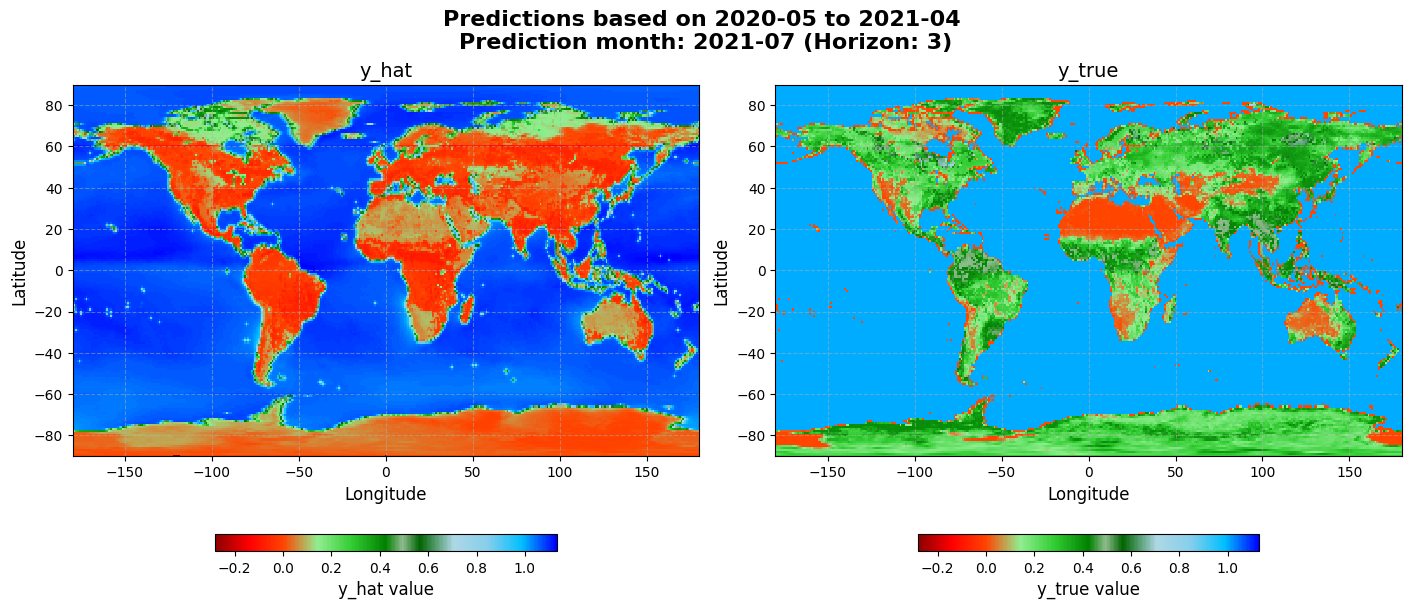

In [85]:
# Example usage:
# Plot the first time step and the first horizon
plot_time_horizon_map(ds_predictions, time_idx=1, horizon_idx=2)
